In [1]:
import os
import numpy as np
import datetime
from tensorflow_core.python.keras.callbacks import EarlyStopping
from tensorflow_core.python.keras.utils import np_utils
from tensorflow_core.python.keras.models import Sequential
from tensorflow_core.python.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.python import math_ops
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow_core.python.keras.layers import Activation
from tensorflow_core.python.keras.utils import get_custom_objects   # 自定義gelu

np.random.seed(10)

In [2]:
Tr_ver = 'orig_50_M_librosa_'
Te_ver = 'orig_50_M_librosa_'

Tr_ver = 'pe_50_M_librosa_'
Te_ver = 'pe_50_M_librosa_'

Tr_ver += '2_'
Te_ver += '2_'

shape = 50

now_path = r'D:\TIMITDIC_231101'
data_path = now_path + '_data_AIS'

Tr_CDF_path = os.path.join(data_path, 'TRAIN', 'cnn_dataset')
Te_CDF_path = os.path.join(data_path, 'TEST', 'cnn_dataset')

Tr_DS_path = os.path.join(Tr_CDF_path, 'mfcc', Tr_ver + 'SoundDataset.npz')

Te_DS_path = os.path.join(Te_CDF_path, 'mfcc', Te_ver + 'SoundDataset.npz')

In [3]:
Tr_DS = np.load(Tr_DS_path)
Te_DS = np.load(Te_DS_path)

train_value, train_label = Tr_DS['TrainValue'], Tr_DS['TrainLabel_class']
test_value, test_label = Te_DS['TestValue'], Te_DS['TestLabel_class']
# test_value, test_label, test_label2 = Te_DS['TestValue'], Te_DS['TestLabel_class'], Te_DS['TestLabel_type']

train_value_4D = train_value.reshape(train_value.shape[0], shape, shape, 1).astype('float32')
test_value_4D = test_value.reshape(test_value.shape[0], shape, shape, 1).astype('float32')

# 向量轉換為二進制(只有0和1)的矩陣類型
# 但train_label、test_label原先資料就都是0跟1?
train_label_OneHot = np_utils.to_categorical(train_label)
test_label_OneHot = np_utils.to_categorical(test_label)

In [4]:
class Davis( Activation ):    
    def __init__(self, activation, **kwargs):
        super(Davis, self).__init__(activation, **kwargs)
        self.__name__ = 'custom_gelu'

def custom_gelu(x):
    return 0.5 * x * (1 + math_ops.tanh(math_ops.sqrt(2 / np.pi) * (x + 0.044715 * math_ops.pow(x, 3))))

get_custom_objects().update({'custom_gelu': Davis(custom_gelu)})
get_custom_objects().update({'Davis': (Activation)})

In [5]:
activation_cate = 'relu'
# activation_cate = 'custom_gelu'
# activation_cate = 'sigmoid'
# activation_cate = 'elu'
# activation_cate = 'tanh'
kernel_size = 3

model = Sequential()
model.add(Conv2D(32, (kernel_size, kernel_size), input_shape=(shape, shape, 1), padding='same', activation=activation_cate))
model.add(Conv2D(32, (kernel_size, kernel_size), padding='same', activation=activation_cate))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(32, (kernel_size, kernel_size), padding='same', activation=activation_cate))
model.add(Conv2D(64, (kernel_size, kernel_size), padding='same', activation=activation_cate))
# model.add(Conv2D(128, (3, 3), padding='same', activation='custom_gelu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='custom_gelu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation=activation_cate))
# model.add(Dropout(0.2))
model.add(Dense(128, activation=activation_cate))
model.add(Dropout(0.5))
# model.add(Dense(32, activation=activation_cate))
# model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
model.summary()
model.compile(loss='binary_crossentropy',  # mean_squared_error, binary_crossentropy, categorical_crossentropy
              optimizer="adam",  # sgd, rmsprop, adam
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0

In [7]:
# 創建一個早停法的回調函數
# early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
# early_stopping = EarlyStopping(monitor='val_acc', patience=100, restore_best_weights=True)

train_history=model.fit(x=train_value_4D,
                        y=train_label_OneHot,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=10,
                        verbose=2,
                        # callbacks=[early_stopping])
                        )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 167 samples, validate on 42 samples
Epoch 1/100
167/167 - 3s - loss: 0.5919 - acc: 0.6487 - val_loss: 0.5956 - val_acc: 0.6667
Epoch 2/100
167/167 - 0s - loss: 0.5763 - acc: 0.6607 - val_loss: 0.5778 - val_acc: 0.6667
Epoch 3/100
167/167 - 0s - loss: 0.5530 - acc: 0.6906 - val_loss: 0.5588 - val_acc: 0.6667
Epoch 4/100
167/167 - 0s - loss: 0.5167 - acc: 0.7445 - val_loss: 0.4553 - val_acc: 0.8175
Epoch 5/100
167/167 - 0s - loss: 0.4101 - acc: 0.8343 - val_loss: 0.3882 - val_acc: 0.8730
Epoch 6/100
167/167 - 0s - loss: 0.3782 - acc: 0.8483 - val_loss: 0.2837 - val_acc: 0.9127
Epoch 7/100
167/167 - 0s - loss: 0.3023 - acc: 0.8762 - val_loss: 0.2441 - val_acc: 0.9206
Epoch 8/100
167/167 - 0s - loss: 0.2720 - acc: 0.8822 - val_loss: 0.1925 - val_acc: 0.9127
Epoch 9/100
167/167 - 0s - loss: 0.2125 - acc: 0.9261 - val_loss: 0.1590 - val_acc: 0.9206
Epoch 10/100
167/167 - 0s - loss: 0.1794 -

{'loss': [0.5919229059876082, 0.5763443554946762, 0.5530166733050774, 0.5166904551540307, 0.4101244894687287, 0.37818025846681197, 0.3023218616040167, 0.2720202908009112, 0.21250435785797542, 0.17939216708262523, 0.18762998443520712, 0.16086670651496526, 0.12778677482403325, 0.11006097359621819, 0.10493908057401995, 0.09841562566642989, 0.11721224727075615, 0.1149494068719402, 0.110068293508633, 0.07832306857248016, 0.1633681251282642, 0.09471808058839894, 0.061682149628456126, 0.057918880668100706, 0.06176782924191145, 0.10837145454757763, 0.06222274721966789, 0.06361150013249435, 0.06468163718958106, 0.046858525120452445, 0.03949775728390754, 0.03525653919491751, 0.03346476766363414, 0.03555416207811373, 0.05964472059075436, 0.027328713558581838, 0.03703891873062717, 0.02366945096865836, 0.015175641346022693, 0.02238155243680023, 0.05687078271757365, 0.022972867540483784, 0.042796786402597535, 0.016653580154029523, 0.011423987087235484, 0.011646354637269032, 0.015206857074885054, 0.0

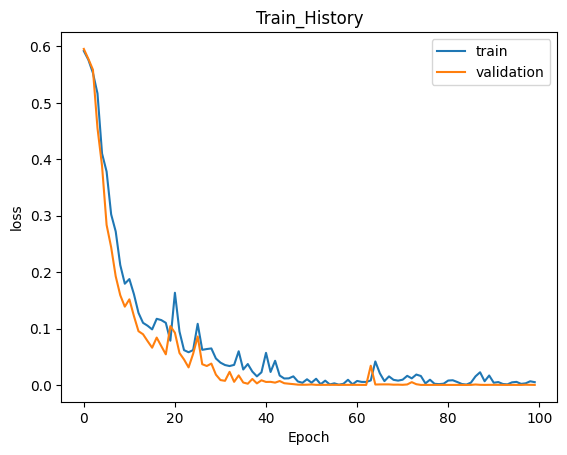

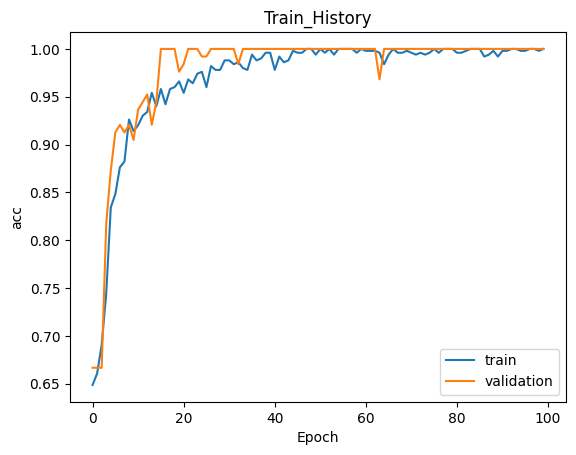

In [8]:
now_str = datetime.datetime.now()
now_str = datetime.datetime.strftime(now_str, '%Y%m%d_%H%M%S')

def show_train_history(train_history, train, validation):
    # 定義show_train_history函數，輸入下列參數:之前訓練過程所產生的train_history、
    # ...訓練資料的執行結果、驗證資料的執行結果
    print(train_history.history)
    plt.style.use('default')
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train_History')  # 顯示圖的標題
    plt.ylabel(train)  # 顯示y軸的標籤
    plt.xlabel('Epoch')  # 設定x軸標籤是'Epoch'
    plt.legend(['train', 'validation'], loc='best')
    # 設定國例是顯示'train', 'validation',位置在左上角

    train_history_path = os.path.join(now_path, 'train_history', Tr_ver)
    os.makedirs(train_history_path, exist_ok=True)

    plt.savefig(os.path.join(train_history_path, now_str + '_' + train + '.png'), bbox_inches='tight', pad_inches=0)

    plt.show()

show_train_history(train_history, 'loss', 'val_loss')
show_train_history(train_history, 'acc', 'val_acc')
# show_train_history(train_history, 'accuracy', 'val_accuracy')

In [9]:
scores = model.evaluate(test_value_4D, test_label_OneHot)
print('loss=', scores[0], '\nacc=', scores[1])

f = open(os.path.join(now_path, 'train_history', 'train_history.txt'), 'a+')  # a+

content = f.read()
f.seek(0, 0)

f.write('\n' + '---------------------------------' + '\n')
f.write('\n' + '*****' + Tr_ver + '*****' + '\n')
f.write(now_str + '\n')
f.write('loss=' + '\n' + str(scores[0]) + '\n')
f.write('acc=' + '\n' + str(scores[1]))

f.write('\n' + content)
f.close()

42/42 [==============================] - 0s 3ms/sample - loss: 2.3104e-05 - acc: 1.0000
loss= 2.3103518677609308e-05 
acc= 1.0


In [10]:
# 使用pd.crosstab建立混淆矩陣，輸入下列參數:
prediction = model.predict_classes(test_value_4D)
pd.crosstab(test_label,  # 測試資料數字影像的其實值
            prediction,  # 測試資料數字影像的預測結果
            rownames=['label'],  # 設定行的名稱是label
            colnames=['predict'])  # 設定列的名稱是predict

predict,0,1,2
label,,,
0,16,0,0
1,0,21,0
2,0,0,5


In [11]:
MWpath = os.path.join(now_path, '..\..', 'model_weight')
os.makedirs(MWpath, exist_ok=True)
Wver = now_path.split('\\')[-1]
model.save(os.path.join(MWpath, Tr_ver + 'SoundWeight_' + Wver + '_type2.h5'))